In [31]:
# entire code is being run on an Ubuntu kernel. 
# not many QoL libraries are needed.
# your mileage may vary.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# training specific imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

# dataset imports
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Resize, ToPILImage, Lambda
import torchvision.transforms as transforms

# AI imports
import torch
import torch.nn as nn

# statistics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support, roc_curve

# test if GPU acceleration is working
torch.cuda.is_available()

True

In [32]:
# load dataset annotations file
dataset = pd.read_csv('./disaster-dataset/annotations.csv', delimiter=';')
dataset.head()

,id,filename,A1.Q1,A1.Q2,A1.Q3.1,A1.Q3.2,A1.Q3.3,A1.Q3.4,A1.Q3.5,A1.Q3.6,...,A5.Q4.8,A5.Q4.9,A5.Q4.10,A5.Q5.1,A5.Q5.2,A5.Q5.3,A5.Q5.4,A5.Q5.5,A5.Q5.6,A5.Q5.7
0,052464df-5fdb-428a-9a4a-6036ea023b42,052464df-5fdb-428a-9a4a-6036ea023b42.jpg,4,7,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
1,2ce9b1bc-ee70-4128-85d1-0fd3ac272619,2ce9b1bc-ee70-4128-85d1-0fd3ac272619.jpg,6,5,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2280b9f3-6989-4222-a0d9-ec4bd35d731b,2280b9f3-6989-4222-a0d9-ec4bd35d731b.jpg,7,9,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,257a8e84-7738-49e2-9945-7f082bf7ad34,257a8e84-7738-49e2-9945-7f082bf7ad34.jpg,1,5,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,3f6b222a-049c-4803-9cbb-5ea734110ed0,3f6b222a-049c-4803-9cbb-5ea734110ed0.jpg,1,9,0,1,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0


In [33]:
dataset.isna().sum().sum() == 0

True

### FIND A WAY TO CONDENSE 132 COLUMNS DOWN

15/9/23 Update: Solved with the help of a professor. Every annotator is now a valid output, and the data is to be trained using Cross Validation. See [ISSUE #8](https://github.com/projectayre/ayre/issues/8) for more details

In [34]:
questions = np.array(list([i[3:] for i in dataset.columns[2:28]]))

In [35]:
questions

array(['Q1', 'Q2', 'Q3.1', 'Q3.2', 'Q3.3', 'Q3.4', 'Q3.5', 'Q3.6', 'Q3.7',
       'Q4.1', 'Q4.2', 'Q4.3', 'Q4.4', 'Q4.5', 'Q4.6', 'Q4.7', 'Q4.8',
       'Q4.9', 'Q4.10', 'Q5.1', 'Q5.2', 'Q5.3', 'Q5.4', 'Q5.5', 'Q5.6',
       'Q5.7'], dtype='<U5')

I will rename these using the proper names given to them in [info.txt](./disaster-dataset/info.txt)

In [36]:
values = ['Sentiment polarity', 'Stimulation and excitement', # Continuous output (1-9, needs normalization)
          'Joy', 'Sadness', 'Fear', 'Disgust', 'Anger', 'Surprise', 'Neutral', # Category 1 (Major emotion)
          'Anger', 'Anxiety', 'Craving', 'Emphatic pain', 'Fear', 'Horror', 
          'Joy', 'Relief', 'Sadness', 'Surprise', # Category 2 (Specific emotion)
          'Human facial expression gesture', 'Inherent image property', 'Image background', 
          'Objects in image', 'Text in image', 'Emoji sticker', 'Halo effect'] # Category 3 (Reason for emotion)
rename_dict = dict(zip(questions, values))
len(rename_dict) == len(questions) # Inconsistency has been resolved.

True

In [37]:
rename_dict

{'Q1': 'Sentiment polarity',
 'Q2': 'Stimulation and excitement',
 'Q3.1': 'Joy',
 'Q3.2': 'Sadness',
 'Q3.3': 'Fear',
 'Q3.4': 'Disgust',
 'Q3.5': 'Anger',
 'Q3.6': 'Surprise',
 'Q3.7': 'Neutral',
 'Q4.1': 'Anger',
 'Q4.2': 'Anxiety',
 'Q4.3': 'Craving',
 'Q4.4': 'Emphatic pain',
 'Q4.5': 'Fear',
 'Q4.6': 'Horror',
 'Q4.7': 'Joy',
 'Q4.8': 'Relief',
 'Q4.9': 'Sadness',
 'Q4.10': 'Surprise',
 'Q5.1': 'Human facial expression gesture',
 'Q5.2': 'Inherent image property',
 'Q5.3': 'Image background',
 'Q5.4': 'Objects in image',
 'Q5.5': 'Text in image',
 'Q5.6': 'Emoji sticker',
 'Q5.7': 'Halo effect'}

There is the mistake in the dataset, Q4 is supposed only has 9 categories, and Q5 7. However, Q4 has 10 and Q5 has 6. I'm not sure what to do here.

15/9/23: FIXED. Found a research paper done on the same dataset, and it gave me this: https://www.mdpi.com/1424-8220/22/10/3628 

In [38]:
# split into total and test, with 679 test images
train_set = dataset[:3000]
test_set = dataset[3000:]
train_set.shape[0] + test_set.shape[0] == dataset.shape[0]

True

In [39]:
# Write code to seperate blocks out of the dataframe for each annotator so they can be stitched together
train_images = train_set.iloc[:, 1]
test_images = test_set.iloc[:, 1]
train_labels = train_set.drop(['id', 'filename'], axis=1)
test_labels = test_set.drop(['id', 'filename'], axis=1)
train_labellist = []
test_labellist = []
for i in range(5):
    train_labellist.append(train_labels.iloc[:, 26*i:26*(i+1)].to_numpy())
    test_labellist.append(test_labels.iloc[:, 26*i:26*(i+1)].to_numpy())
train_llist = np.vstack(np.array(train_labellist))
test_llist = np.vstack(np.array(test_labellist))
train_llist.shape, test_llist.shape # this is now the stitched block lmao

((15000, 26), (3395, 26))

In [40]:
# convert labellist to dataframe
train_labels = pd.DataFrame(train_llist, columns=values)
test_labels = pd.DataFrame(test_llist, columns=values)
train_labels.head()

,Sentiment polarity,Stimulation and excitement,Joy,Sadness,Fear,Disgust,Anger,Surprise,Neutral,Anger,...,Relief,Sadness,Surprise,Human facial expression gesture,Inherent image property,Image background,Objects in image,Text in image,Emoji sticker,Halo effect
0,4,7,0,0,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,6,5,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
2,7,9,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,5,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
4,1,9,0,1,1,0,0,0,0,0,...,0,1,0,1,0,1,1,0,0,0


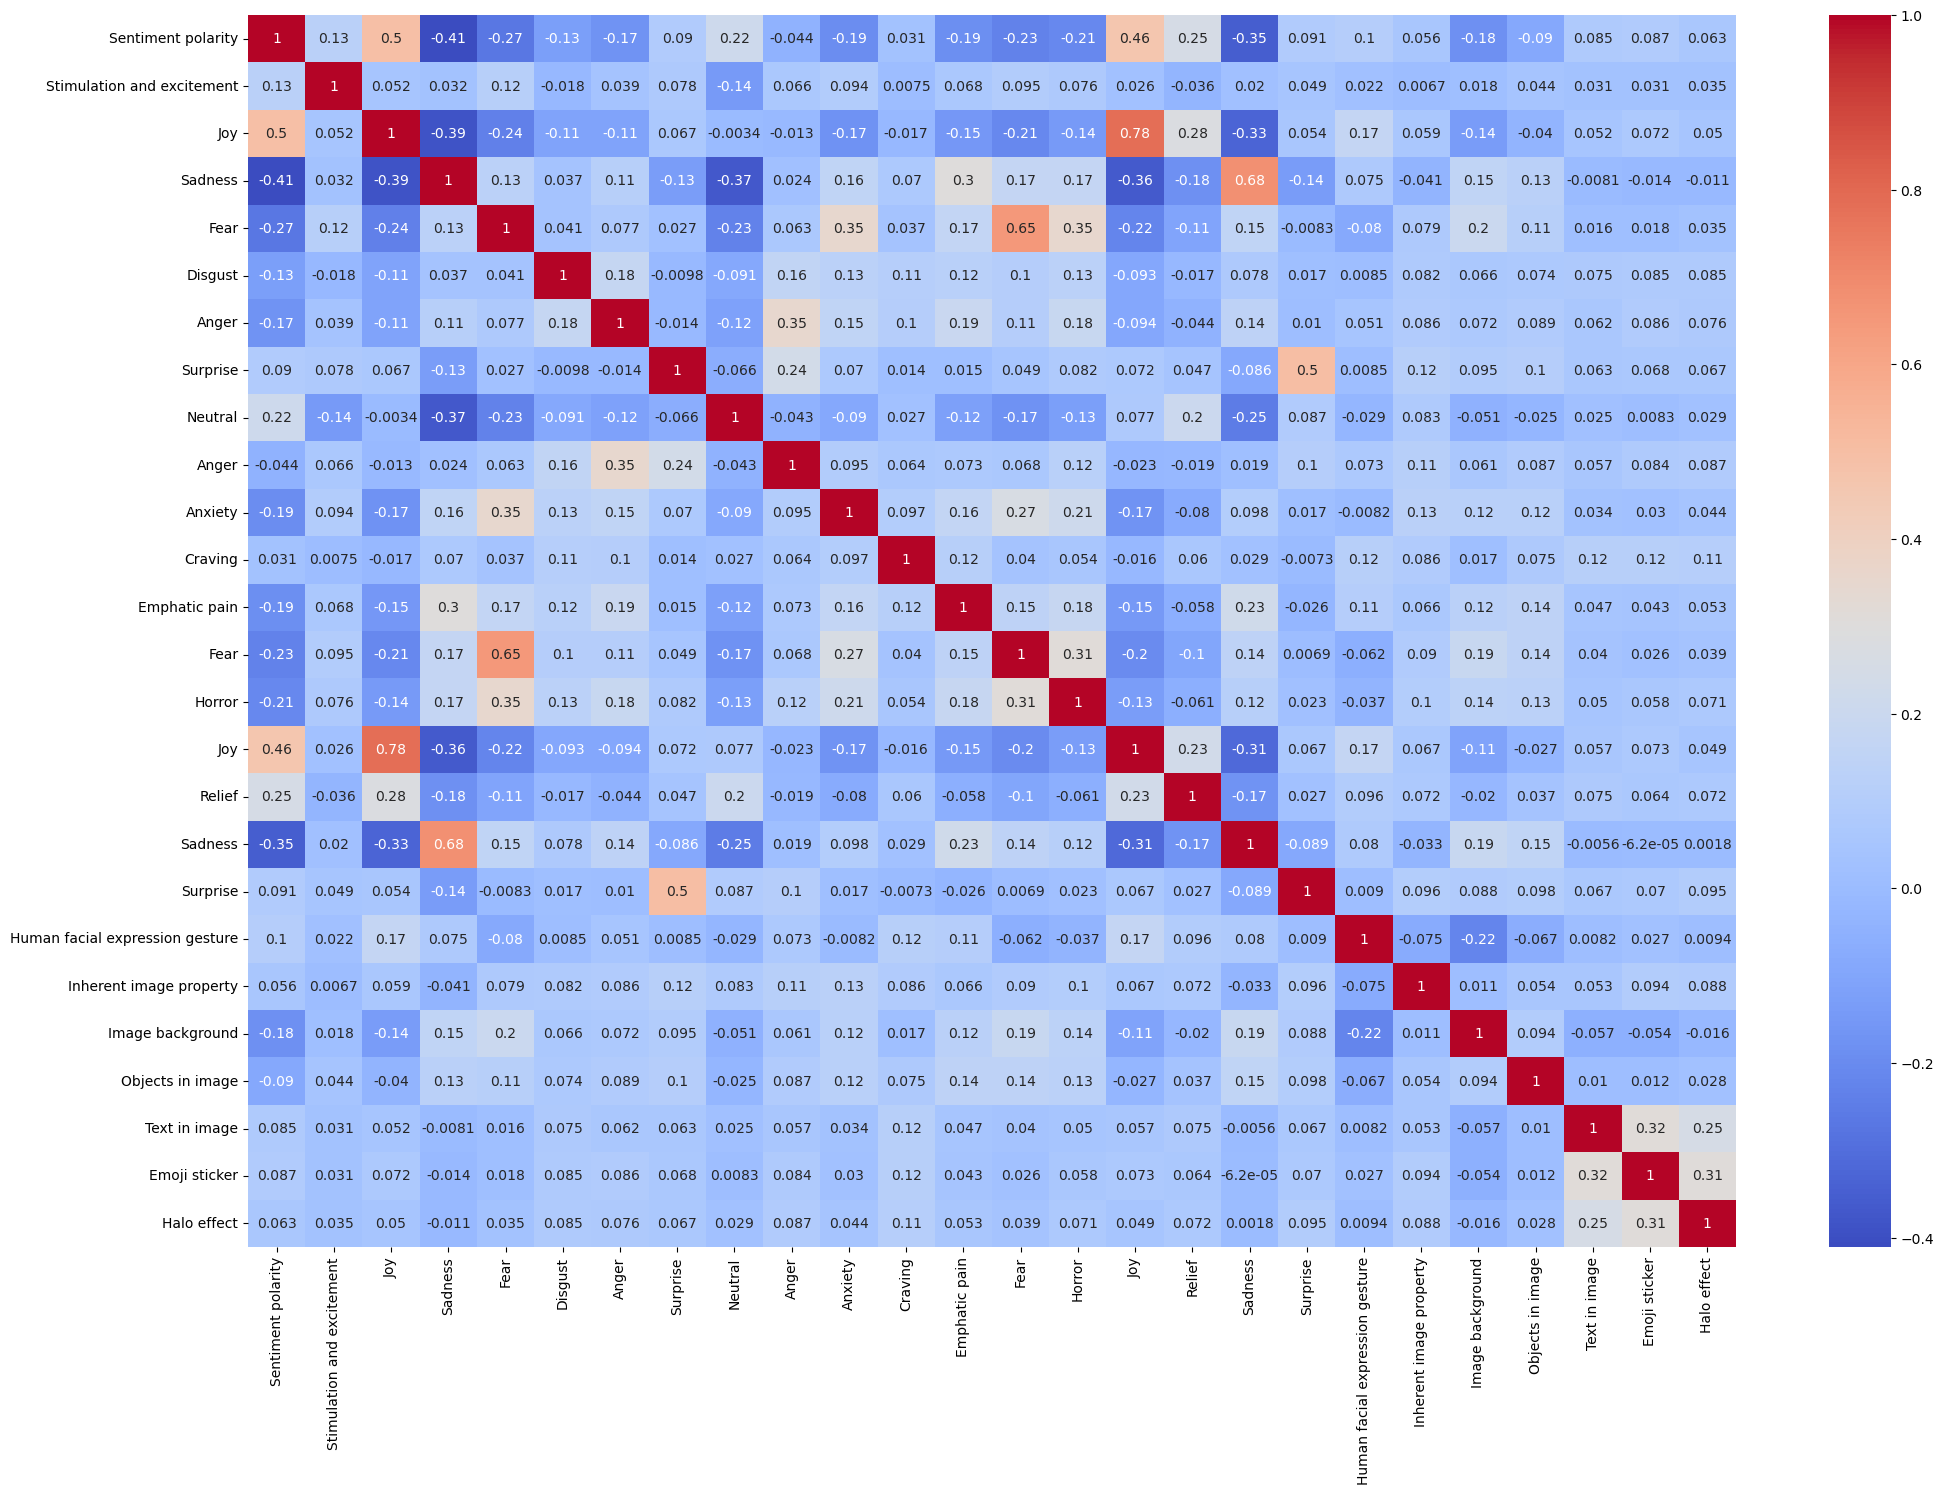

In [41]:
# final correlation between all labels
plt.figure(figsize=(24, 16))
sns.heatmap(train_labels.corr(), cmap='coolwarm', annot=True)
plt.show()

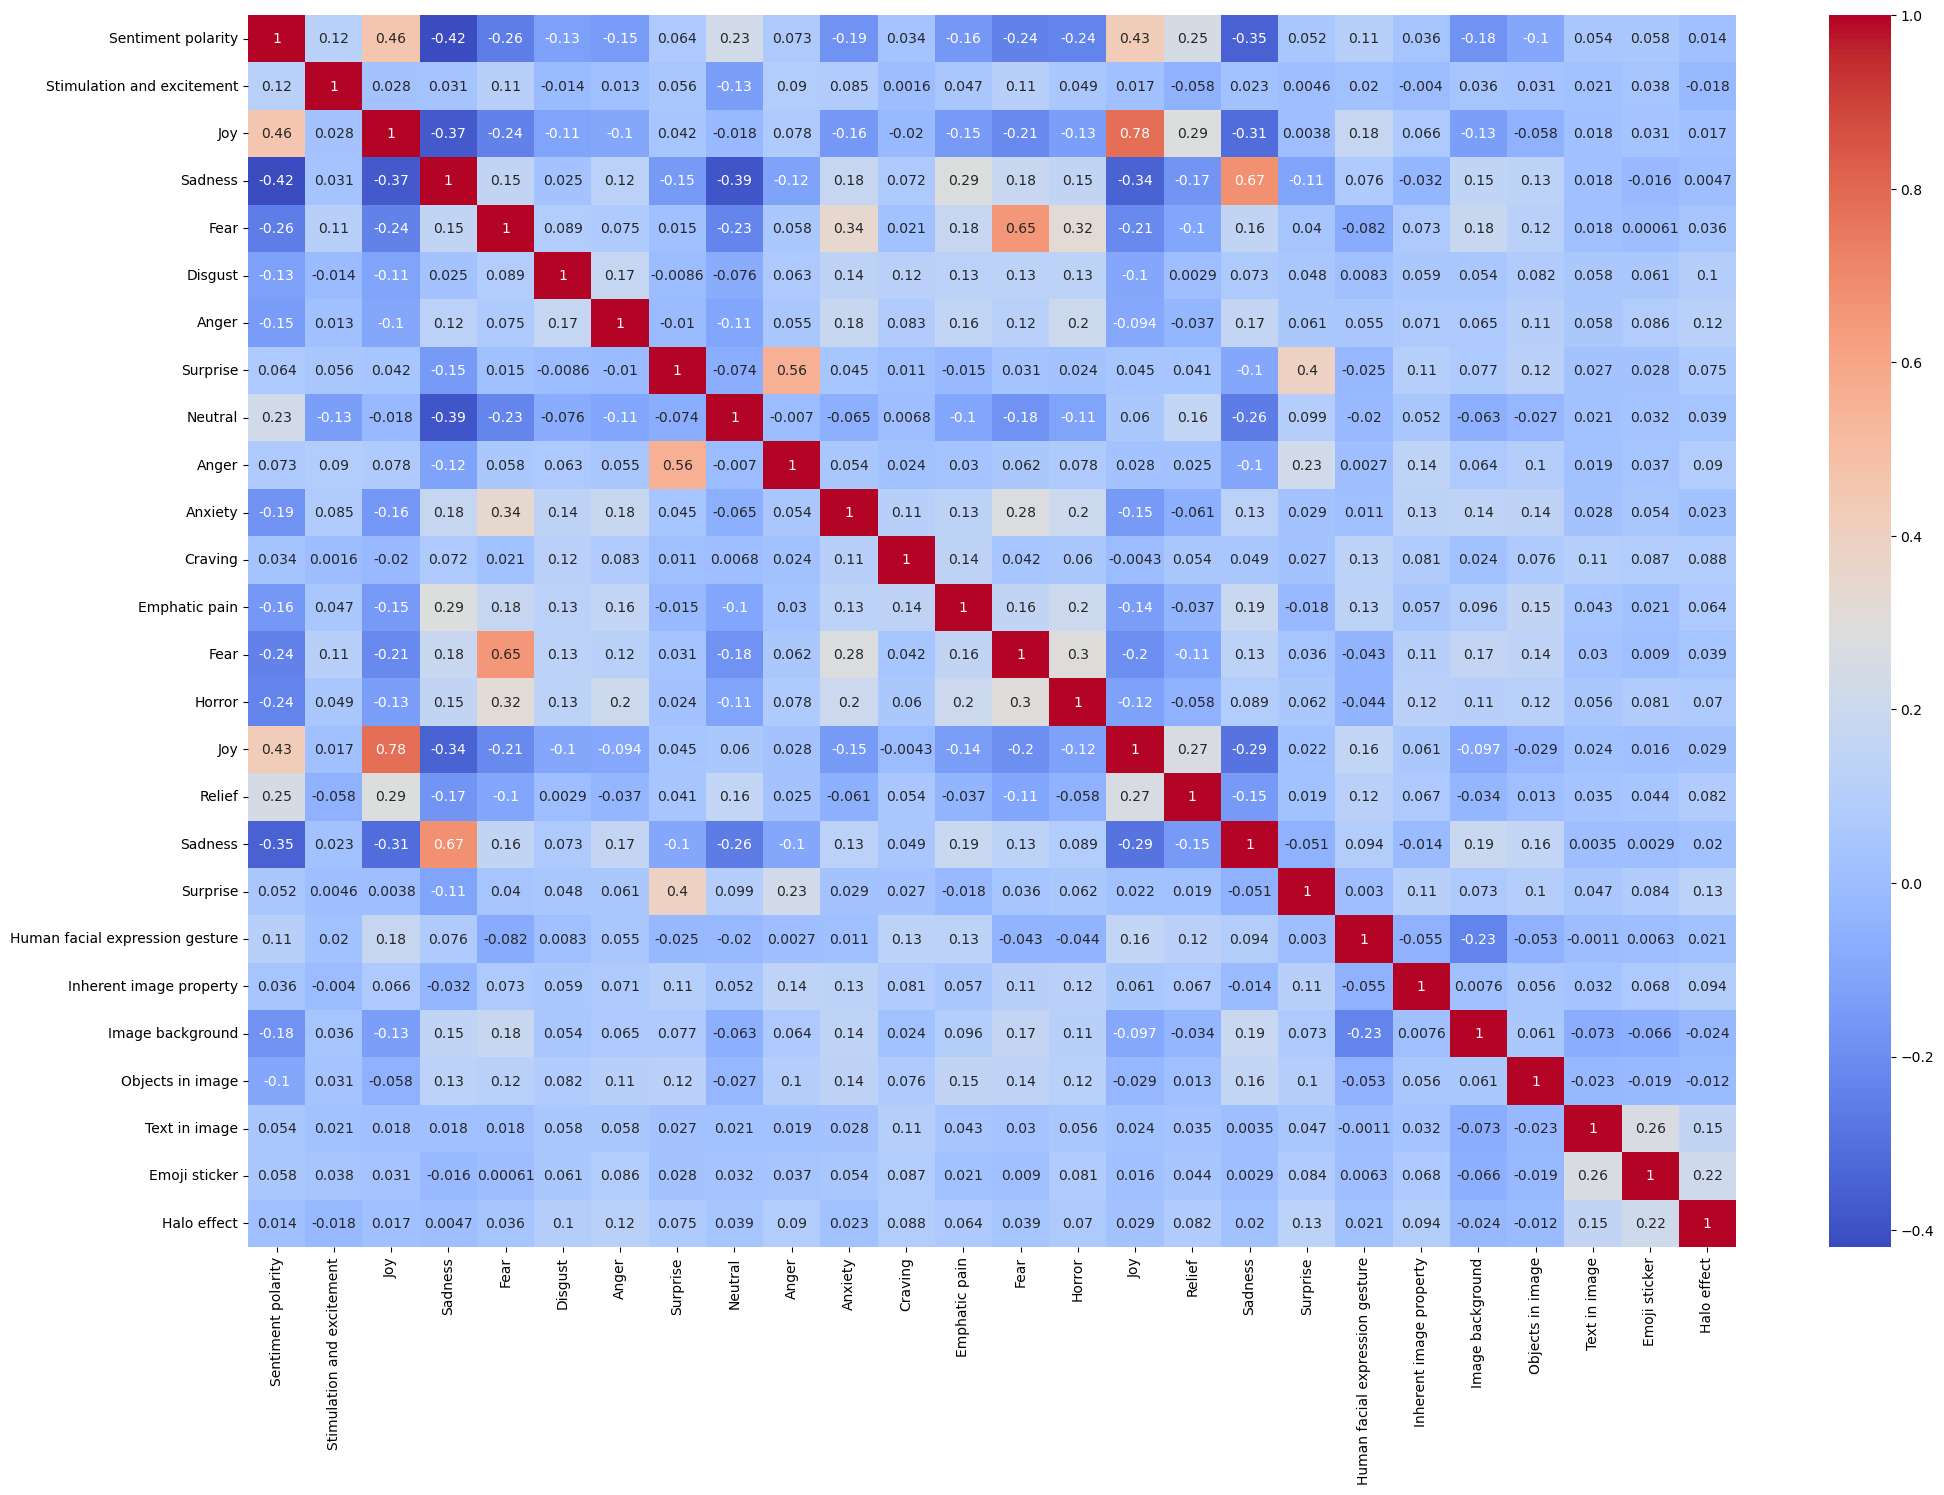

In [42]:
# heatmap between test labels
plt.figure(figsize=(24, 16))
sns.heatmap(test_labels.corr(), cmap='coolwarm', annot=True)
plt.show()

In [43]:
# MinMax Scale the likert scales for better multilabel classification
scaled_labels = MinMaxScaler().fit_transform(train_labels.iloc[:, 0:2])
train_labels['Sentiment polarity'] = scaled_labels[:, 0]
train_labels['Stimulation and excitement'] = scaled_labels[:, 1]
test_scaled_labels = MinMaxScaler().fit_transform(test_labels.iloc[:, 0:2])
test_labels['Sentiment polarity'] = test_scaled_labels[:, 0]
test_labels['Stimulation and excitement'] = test_scaled_labels[:, 1]
train_labels.describe()

,Sentiment polarity,Stimulation and excitement,Joy,Sadness,Fear,Disgust,Anger,Surprise,Neutral,Anger,...,Relief,Sadness,Surprise,Human facial expression gesture,Inherent image property,Image background,Objects in image,Text in image,Emoji sticker,Halo effect
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,0.387450,0.632342,0.134000,0.588867,0.335333,0.100867,0.100933,0.179733,0.158867,0.160267,...,0.103267,0.520267,0.158733,0.419800,0.222400,0.655667,0.395933,0.021933,0.013333,0.015933
std,0.349939,0.284928,0.340664,0.492056,0.472123,0.301162,0.301250,0.383978,0.365564,0.366865,...,0.304317,0.499606,0.365439,0.493542,0.415872,0.475166,0.489067,0.146471,0.114701,0.125222
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.375000,0.625000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.625000,0.875000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
test_labels.describe()

,Sentiment polarity,Stimulation and excitement,Joy,Sadness,Fear,Disgust,Anger,Surprise,Neutral,Anger,...,Relief,Sadness,Surprise,Human facial expression gesture,Inherent image property,Image background,Objects in image,Text in image,Emoji sticker,Halo effect
count,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,...,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000
mean,0.376325,0.640611,0.116642,0.580854,0.340795,0.096613,0.105449,0.196465,0.161708,0.243594,...,0.088954,0.516642,0.122828,0.374963,0.234168,0.689249,0.407069,0.020619,0.009426,0.014728
std,0.352050,0.288976,0.321041,0.493492,0.474046,0.295473,0.307177,0.397383,0.368237,0.429313,...,0.284720,0.499797,0.328288,0.484185,0.423540,0.462869,0.491360,0.142125,0.096641,0.120478
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.250000,0.625000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.625000,0.875000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
# stitch the labels with the labels to create final dataframes for both.
trainimg = pd.concat([train_images]*5).reset_index(drop=True)
testimg = pd.concat([test_images]*5).reset_index(drop=True)
train_labels.insert(loc=0, column='Filename', value=trainimg)
train_labels.head()

,Filename,Sentiment polarity,Stimulation and excitement,Joy,Sadness,Fear,Disgust,Anger,Surprise,Neutral,...,Relief,Sadness,Surprise,Human facial expression gesture,Inherent image property,Image background,Objects in image,Text in image,Emoji sticker,Halo effect
0,052464df-5fdb-428a-9a4a-6036ea023b42.jpg,0.375,0.75,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
1,2ce9b1bc-ee70-4128-85d1-0fd3ac272619.jpg,0.625,0.50,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
2,2280b9f3-6989-4222-a0d9-ec4bd35d731b.jpg,0.750,1.00,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,257a8e84-7738-49e2-9945-7f082bf7ad34.jpg,0.000,0.50,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
4,3f6b222a-049c-4803-9cbb-5ea734110ed0.jpg,0.000,1.00,0,1,1,0,0,0,0,...,0,1,0,1,0,1,1,0,0,0


In [46]:
test_labels.insert(loc=0, column='Filename', value=testimg)
test_labels.head()

,Filename,Sentiment polarity,Stimulation and excitement,Joy,Sadness,Fear,Disgust,Anger,Surprise,Neutral,...,Relief,Sadness,Surprise,Human facial expression gesture,Inherent image property,Image background,Objects in image,Text in image,Emoji sticker,Halo effect
0,e991e17b-1e4b-43e6-a05d-a025d7e1c20a.jpg,0.375,0.875,0,0,1,0,0,1,0,...,0,0,1,0,1,1,0,0,0,1
1,4f89d359-6788-4b71-ad1a-1f3cd95a16ef.jpg,0.000,1.000,0,0,1,0,0,0,0,...,0,1,0,0,1,1,0,0,0,0
2,f2f954f0-287a-423b-8c3f-21e7c4ed6f62.jpg,0.000,0.500,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,954a5e15-f99b-4e2f-8d71-90cc9911f468.jpg,0.125,0.750,0,1,0,1,1,0,0,...,1,1,0,1,0,0,0,0,0,1
4,e1a71c6b-a899-4e11-8cfc-cbcd23865ee1.jpg,0.250,1.000,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


# Check the actual images and fix errors that they might have.
## Dataset loading is not consistent.

In [47]:
for File in os.listdir("./disaster-dataset/images/"):
    if not File.endswith(".jpg"):
        print(File)

Strange. all filenames are consistent.

In [48]:
for filename in train_labels['Filename'].values:
    if filename[-4:] != '.jpg':
        print(filename)

All filenames consistent in dataframe too.

In [49]:
for filename in test_labels['Filename'].values:
    if filename[-4:] != '.jpg':
        print(filename)

What is the error here? Going to try iterative method.

In [50]:
# Result already caches, this cell has no purpose anymore

# total_badfiles = []
# root = './disaster-dataset/images/'
# # iterate over every unique filename
# for File in np.concatenate((train_labels['Filename'].unique(), test_labels['Filename'].unique()), axis=0):
#     try:
#         tmpimg = read_image(root + File)
#     except Exception as error:
#         print(f'failed: {root + File} with {error}')
#         total_badfiles.append(File)
# print(f"Total bad files: {len(total_badfiles)}")

In [51]:
# Cache the result of previous cell (saves a lot of time)
total_badfiles = ['1ce8151e-d6b3-491e-b0ed-e62bbdc7d106.jpg',
                  '3f5e30b2-f6e1-4e72-a921-13218e3ad00a.jpg',
                  '65ba83ff-18d9-4f7c-8a91-1c4e0730ca39.jpg',
                  '9c0720a8-8bc5-497d-a721-7ea37dd40076.jpg',
                  '542eb02f-1eb7-42c2-882b-52d3441e6a3d.jpg',
                  '416dc44b-9e53-4a5d-a201-201a265ed8b3.jpg',
                  '7d40d5f2-c280-4f0d-97be-3daf8f51cf92.jpg',
                  '4854acd8-6b9f-4f3f-bcc9-f9fc98acb75d.jpg',
                  '0c416a95-6e96-4e8c-bab3-56b682feafe9.jpg',
                  '68f1e787-e26f-4e70-b143-8ce46780a645.jpg',
                  '87c242f7-9f42-4840-877b-c556e199e620.jpg',
                  '825c9bdd-b659-40bc-a325-c22fd55a25c5.jpg',
                  '4e27458c-3272-42f4-b22f-a2378576c68c.jpg',
                  'be36bfac-afd1-4d6c-9990-758b6bd2a846.jpg',
                  '096d7f71-d74c-4eba-a045-2783bd6565cd.jpg',
                  '0e5c2d2e-8393-4ffe-aa4d-6c79e0a83af3.jpg',
                  '54fb7f47-9dc6-4328-bd6a-df0966053157.jpg',
                  'd4f26d31-c491-4a8e-a712-d46aea06cff3.jpg',
                  'aa366b17-6896-4dc2-a5ef-a7ba2d4900bc.jpg',
                  '44700748-c825-4b9c-8b37-e45218895f13.jpg',
                  '74b2ad66-4a29-438c-9fed-020b6e2b74b0.jpg',
                  'd5f21923-5e48-4ee1-bdbd-0fa0e9eae970.jpg']

In [52]:
# Filter out the bad files from both the dataframes.
train_labels = train_labels[~train_labels['Filename'].isin(total_badfiles)]
test_labels = test_labels[~test_labels['Filename'].isin(total_badfiles)]
train_labels.shape, test_labels.shape

((14920, 27), (3365, 27))

In [53]:
# DELETE the bad files (RUN ONLY ONCE)
# for file in total_badfiles:
#     os.remove(root + file)

# Everything checks out, this completes the preprocessing of the .csv

### Dataset is ready to be converted to a torch object.

In [54]:
# Create a custom dataset class.
class SentimentDataset(Dataset):
    def __init__(self, annotations: pd.DataFrame, img_dir: str, transform=None, target_transform=None):
        """A custom dataset class created for the sentiment analysis portion of project Ayre.
        NOTE: Make sure the annotations entry is the loaded dataframe itself and NOT the filepath.
        This was done to smoothen our own training process."""
        
        self.img_labels = annotations
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.target_names = self.img_labels.columns[1:]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # temp debug step
        # return idx
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1:]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, torch.tensor(label)    
        # advanced return type with label-dictionary
        # return image, dict(zip(self.target_names, label))


In [55]:
# initialize params
root = './disaster-dataset/images/'
img_w = 512
img_h = 512
n_mean = 0.5
n_std = 0.5
# creating a custom transform
preproc = transforms.Compose([
    ToPILImage(),
    Resize((img_h, img_w), antialias=True),
    Lambda(lambda img: img.convert('RGB')),
    ToTensor(),
    # Normalize(mean=[n_mean]*3, std=[n_std]*3) 
    # removed because it results in negative values, and 
    # ToTensor() automatically rescales to .1/255
])

# create dataset objects
train_dataset = SentimentDataset(train_labels, root, transform=preproc)
test_dataset = SentimentDataset(test_labels, root, transform=preproc)

In [56]:
# create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=96, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [57]:
# vertifican cell, do not run this often.

# for i in range(len(train_dataset)):
#     if train_dataset.__getitem__(2)[0].shape != (3, 512, 512):
#         print('wtf is at index', i)

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


Feature batch shape: torch.Size([96, 3, 512, 512])
Labels batch shape: torch.Size([96, 26])


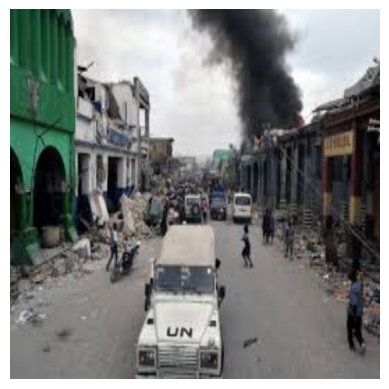

Label: tensor([0.2500, 0.7500, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)


In [58]:
# Display a training image and label.
train_features, train_y = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_y.size()}")
img = train_features[0].squeeze()
label = train_y[0]
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.axis('off')
plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([64, 3, 512, 512])
Labels batch shape: torch.Size([64, 26])


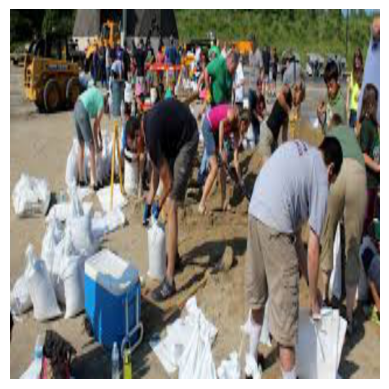

Label: tensor([1.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)


In [59]:
# Display a testing image and label
test_features, test_y = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_y.size()}")
timg = test_features[0].squeeze()
tlabel = test_y[0]
plt.imshow(timg.permute(1, 2, 0), cmap="gray")
plt.axis('off')
plt.show()
print(f"Label: {tlabel}")

## Torch dataset is ready to train, need to create and train the model now.

In [60]:
# save cleaned csv files.
train_labels.to_csv('./disaster-dataset/train.csv')
test_labels.to_csv('./disaster-dataset/test.csv')

OSError: Cannot save file into a non-existent directory: 'misc'